In [59]:
%load_ext autoreload
%autoreload 2

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from lib.models.latent_encoder import LatentEncoder
from lib.models.deepsdf import DeepSDF
from torchvision.transforms import v2
from lib.utils.config import load_config
from lib.data.metainfo import MetaInfo
import hydra
import glob
import cv2
import tqdm
import random
from lib.utils.config import load_config
from lib.data.sampler import ChunkSampler
from lib.data.metainfo import MetaInfo

# set random seed
seed = 42
random.seed(seed)

def to_grayscale(img):
    mean = img.mean(2)
    x = np.stack([mean, mean, mean], axis=2)
    x = x.astype(np.uint8)
    return x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
x = cv2.imread("/home/korth/sketch2shape/data/shapenet_chair_4096/shapes/1a8bbf2994788e2743e99e0cae970928/normals/00006.png")

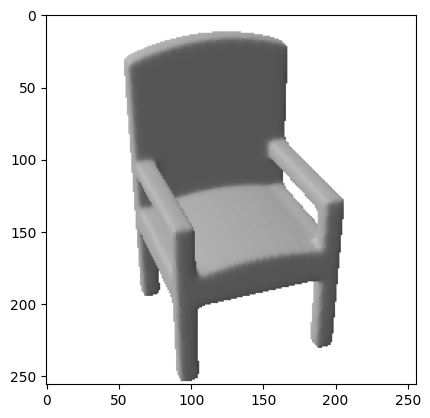

In [61]:
plt.imshow(to_grayscale(x))

In [62]:
dataset_path = "/home/korth/sketch2shape/data/shapenet_chair_4096"
import pandas as pd
metainfo = pd.read_csv(dataset_path + "/metainfo.csv")
metainfo

,obj_id,label,split
0,52310bca00e6a3671201d487ecde379e,0,train
1,2948af0b6a12f1c7ad484915511ccff6,1,train
2,92e2317fd0d0129bb910025244eec99a,2,train
3,1459c329e2123d4fe5b03ab845ae95c,3,train
4,dada2389e96606307aa7cd663df90f18,4,train
...,...,...,...
4475,8fe0e6780b3dabbbb098f5649ee97d24,4475,test
4476,8d458ab12073c371caa2c06fded3ca21,4476,test
4477,8becb5888c900f3a610c2a68437007d6,4477,test
4478,f112035c6413080a664b3b9b23ddfcbc,4478,test


In [63]:
test_obj_ids = metainfo[metainfo['split'] == 'test']['obj_id'].tolist()
test_obj_ids

# white image
white_image = np.ones((256, 256, 3))

options = [6, 7, 11, 12]

img_type = "normals" # sketches

for obj_id in tqdm.tqdm(test_obj_ids):
    selected_view = random.choice(options)
    sketch_path = dataset_path + f"/shapes/{obj_id}/{img_type}/000{selected_view:02d}.png"
    sketch = cv2.imread(sketch_path)

    if img_type == "normals":
        sketch = to_grayscale(sketch)

    plt.subplot(1, 2, 1)
    plt.imshow(sketch)
    plt.xticks([])
    plt.yticks([])

    # add the white image
    plt.subplot(1, 2, 2)
    plt.imshow(white_image)
    plt.xticks([])
    plt.yticks([])
    
    # save the figure
    plt.savefig(f"test_data_collection/{img_type}_{obj_id}.png")

    plt.close()


  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:27<00:00,  9.47it/s]


In [70]:
import os
import cv2

# Path to the folder containing the images
folder_path = "test_data_collection"

# Get the list of image file names in the folder
image_files = glob.glob(os.path.join(folder_path, f"{img_type}_*.png"))

# Sort the image files in ascending order
image_files.sort()

chunk_1 = image_files[:100]
chunk_2 = image_files[100:200]
chunk_3 = image_files[200:]

for i, image_files_chunk in enumerate([chunk_1, chunk_2, chunk_3]):
    # Initialize an empty list to store the images
    images = []

    # Load and append each image to the list
    for image_file in image_files_chunk:
        image = cv2.imread(image_file)
        images.append(image)

    # Combine the images vertically
    combined_image = cv2.vconcat(images)

    # Save the combined image
    combined_image_path = f"combined_image_{img_type}_{i}.png"
    cv2.imwrite(combined_image_path, combined_image)

    # save image as pdf
    from PIL import Image
    image = Image.open(combined_image_path)
    pdf_path = f"combined_image_{img_type}_{i}.pdf"
    image.save(pdf_path)

    cv2.destroyAllWindows()

# store the order of images to disk
with open("order.txt", "w") as f:
    for image_file in image_files:
        f.write(image_file.split('/')[-1][:-4] + "\n")
